# https://micropore.wordpress.com/2011/12/05/pymc-bayesian-fit-fpr-python/


In [1]:
!date
%matplotlib inline

Wed Mar 30 12:02:16 MDT 2016


In [2]:
import pymc
import numpy as np
import spacepy.plot as spp # for the style
import matplotlib.pyplot as plt
import spacepy.toolbox as tb

/Users/balarsen/miniconda3/envs/python3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


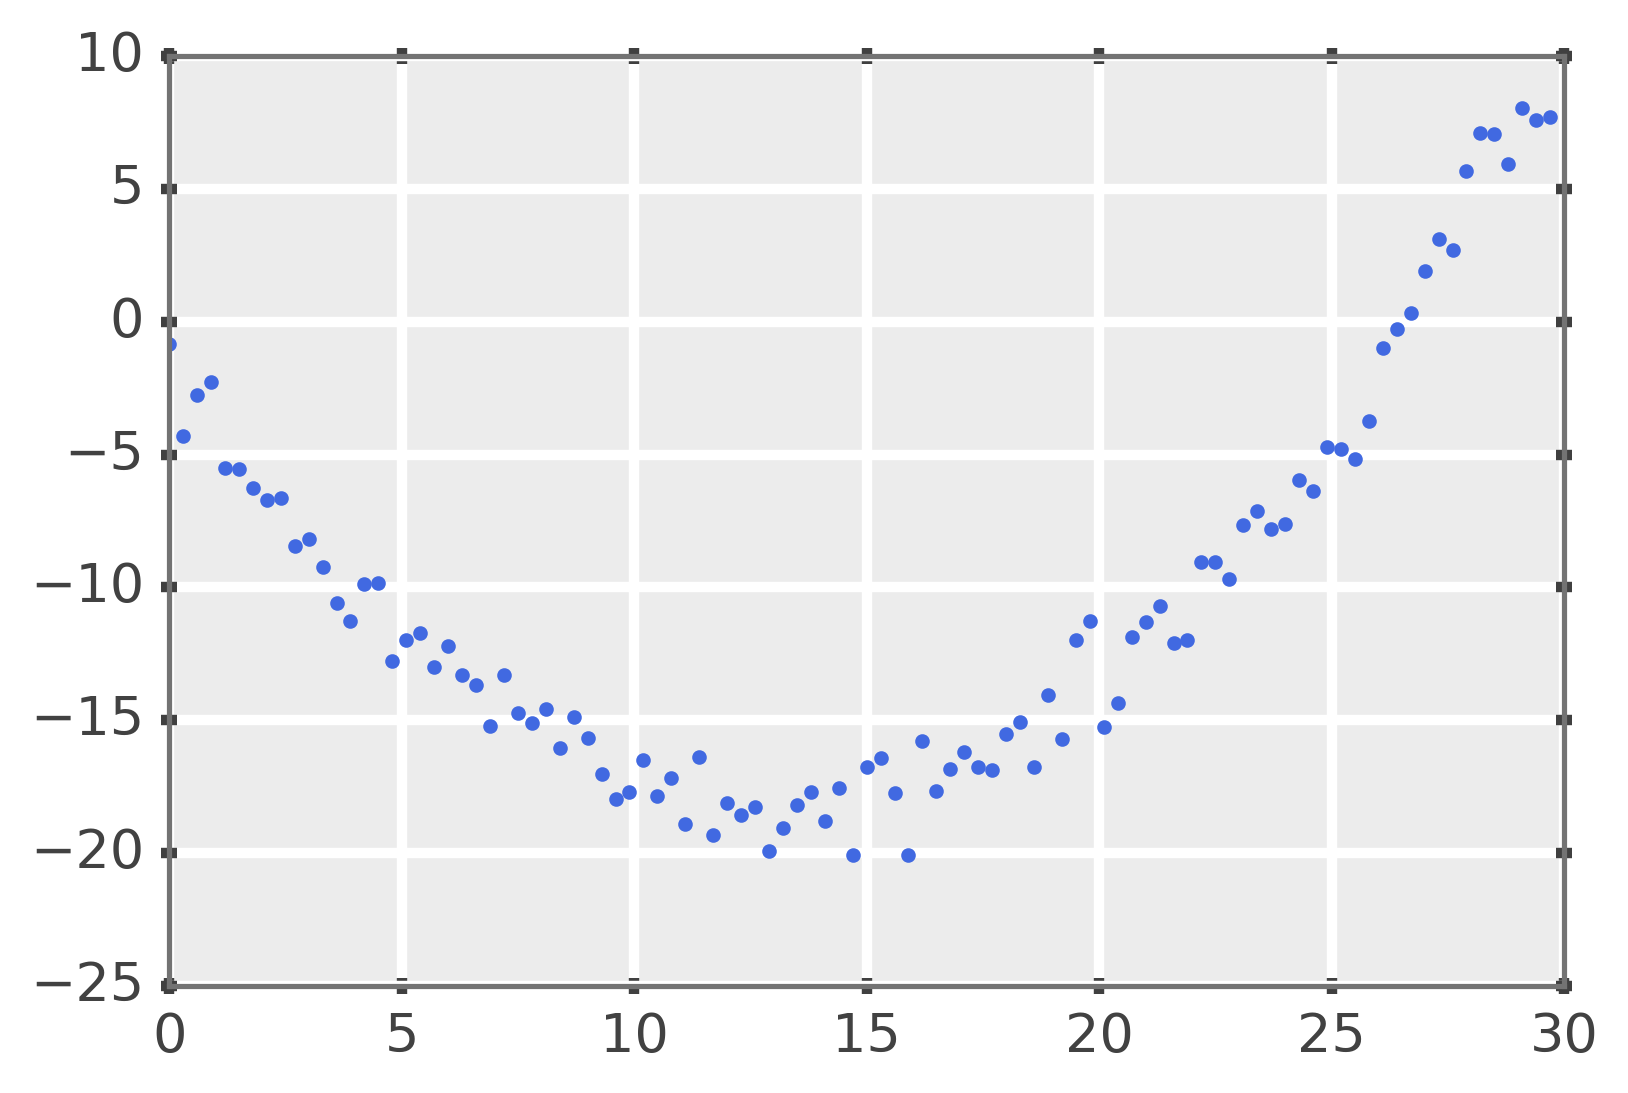

In [3]:
# create some test data
x = np.arange(100) * 0.3
f = 0.1 * x**2 - 2.6 * x - 1.5
np.random.seed(76523654)
noise = np.random.normal(size=100) * 1.     # create some Gaussian noise
f = f + noise                                # add noise to the data
plt.plot(x, f, '.')

In [4]:
# the traditional chi-square fit
z = np.polyfit(x, f, 2)   
print('The chi-square result: ',  z)


The chi-square result:  [ 0.09924399 -2.58796431 -1.42786014]


In [5]:

#priors
sig = pymc.Uniform('sig', 0.0, 100.0, value=1.)

a = pymc.Uniform('a', -10.0, 10.0, value= 0.0)
b = pymc.Uniform('b', -10.0, 10.0, value= 0.0)
c = pymc.Uniform('c', -10.0, 10.0, value= 0.0)

In [6]:

#model
@pymc.deterministic(plot=False)
def mod_quadratic(x=x, a=a, b=b, c=c):
      return a*x**2 + b*x + c

In [7]:

#likelihood
y = pymc.Normal('y', mu=mod_quadratic, tau=1.0/sig**2, value=f, observed=True)
#———————————————————–


 [-----------------100%-----------------] 50000 of 50000 complete in 10.8 secCould not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.
Plotting sig
Plotting b
Plotting a
Plotting c

sig:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	1.12             0.081            0.001            [ 0.964  1.277]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.977            1.062           1.115          1.171         1.297
	

b:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-2.589           0.055            0.005            [-2.695 -2.476]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|

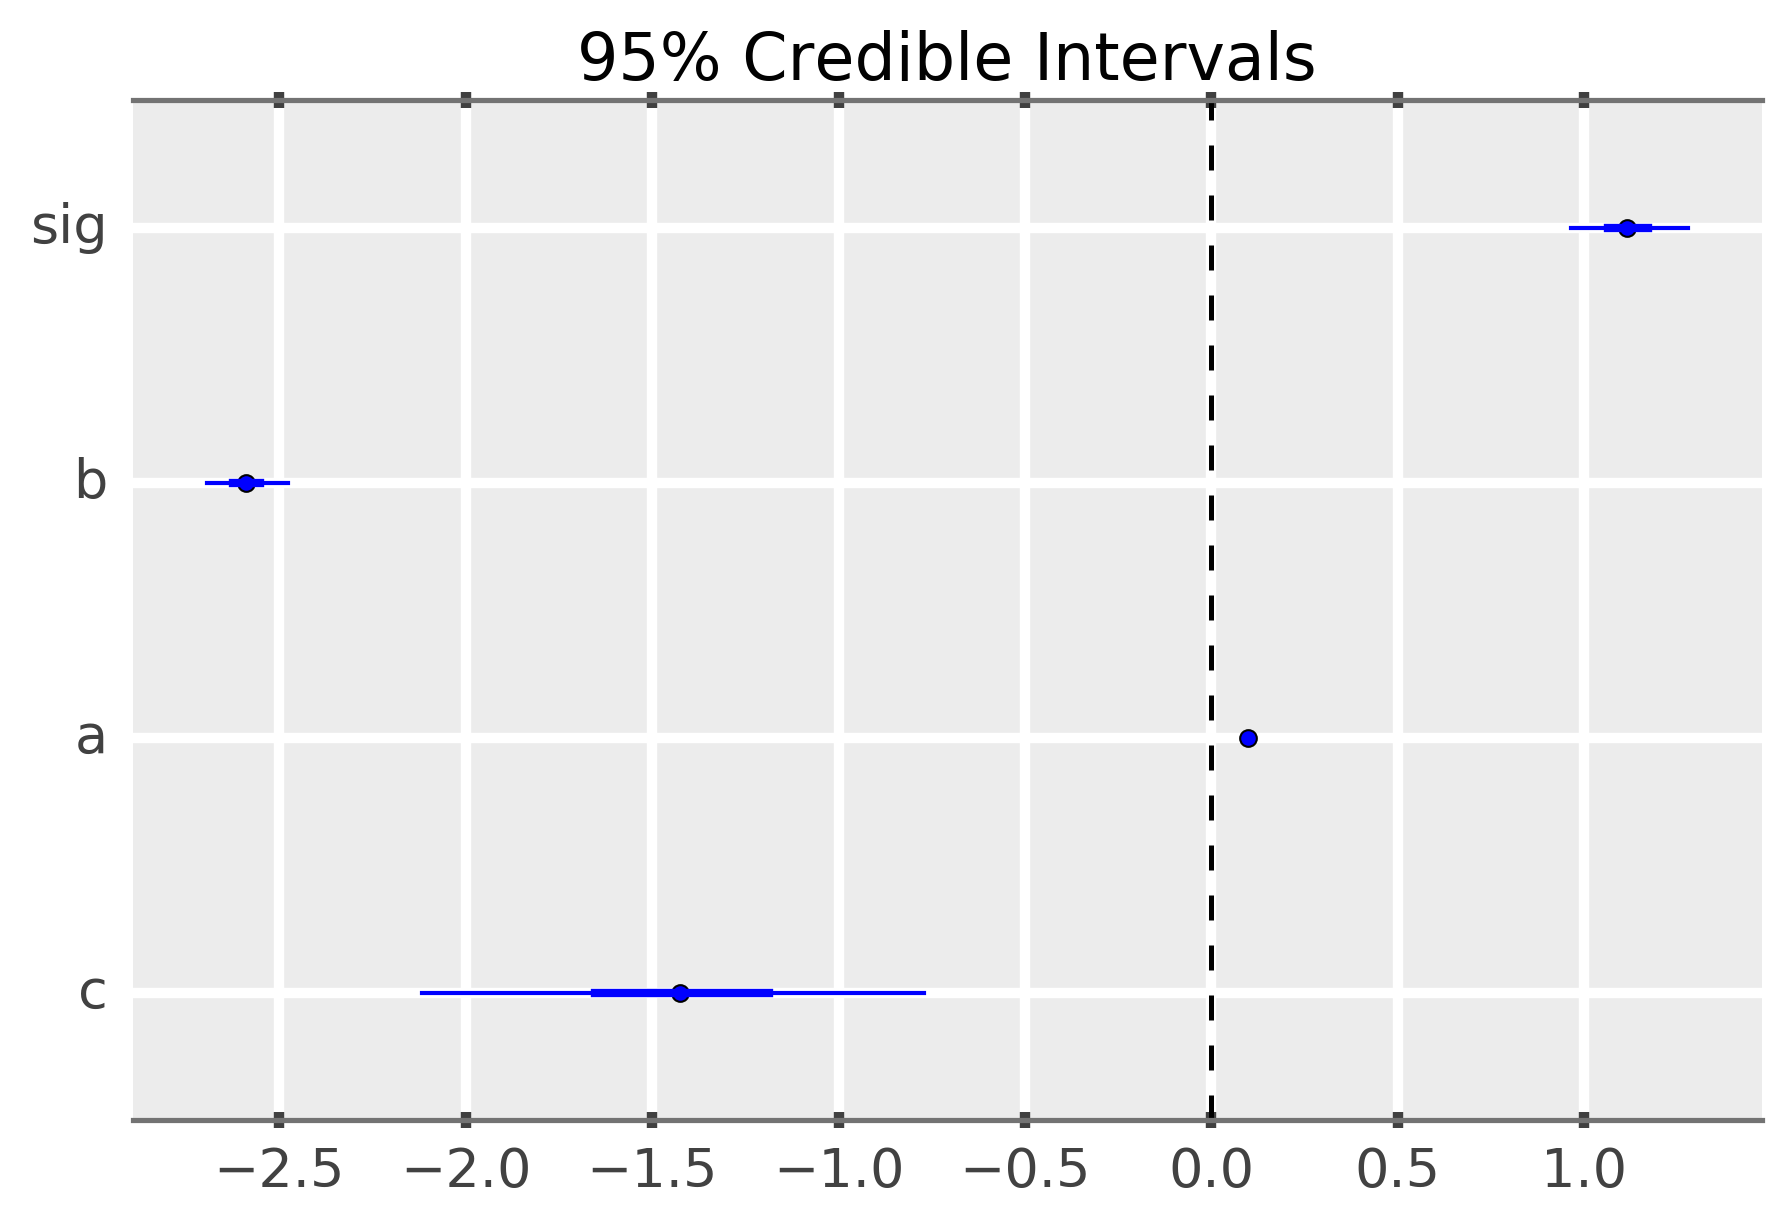

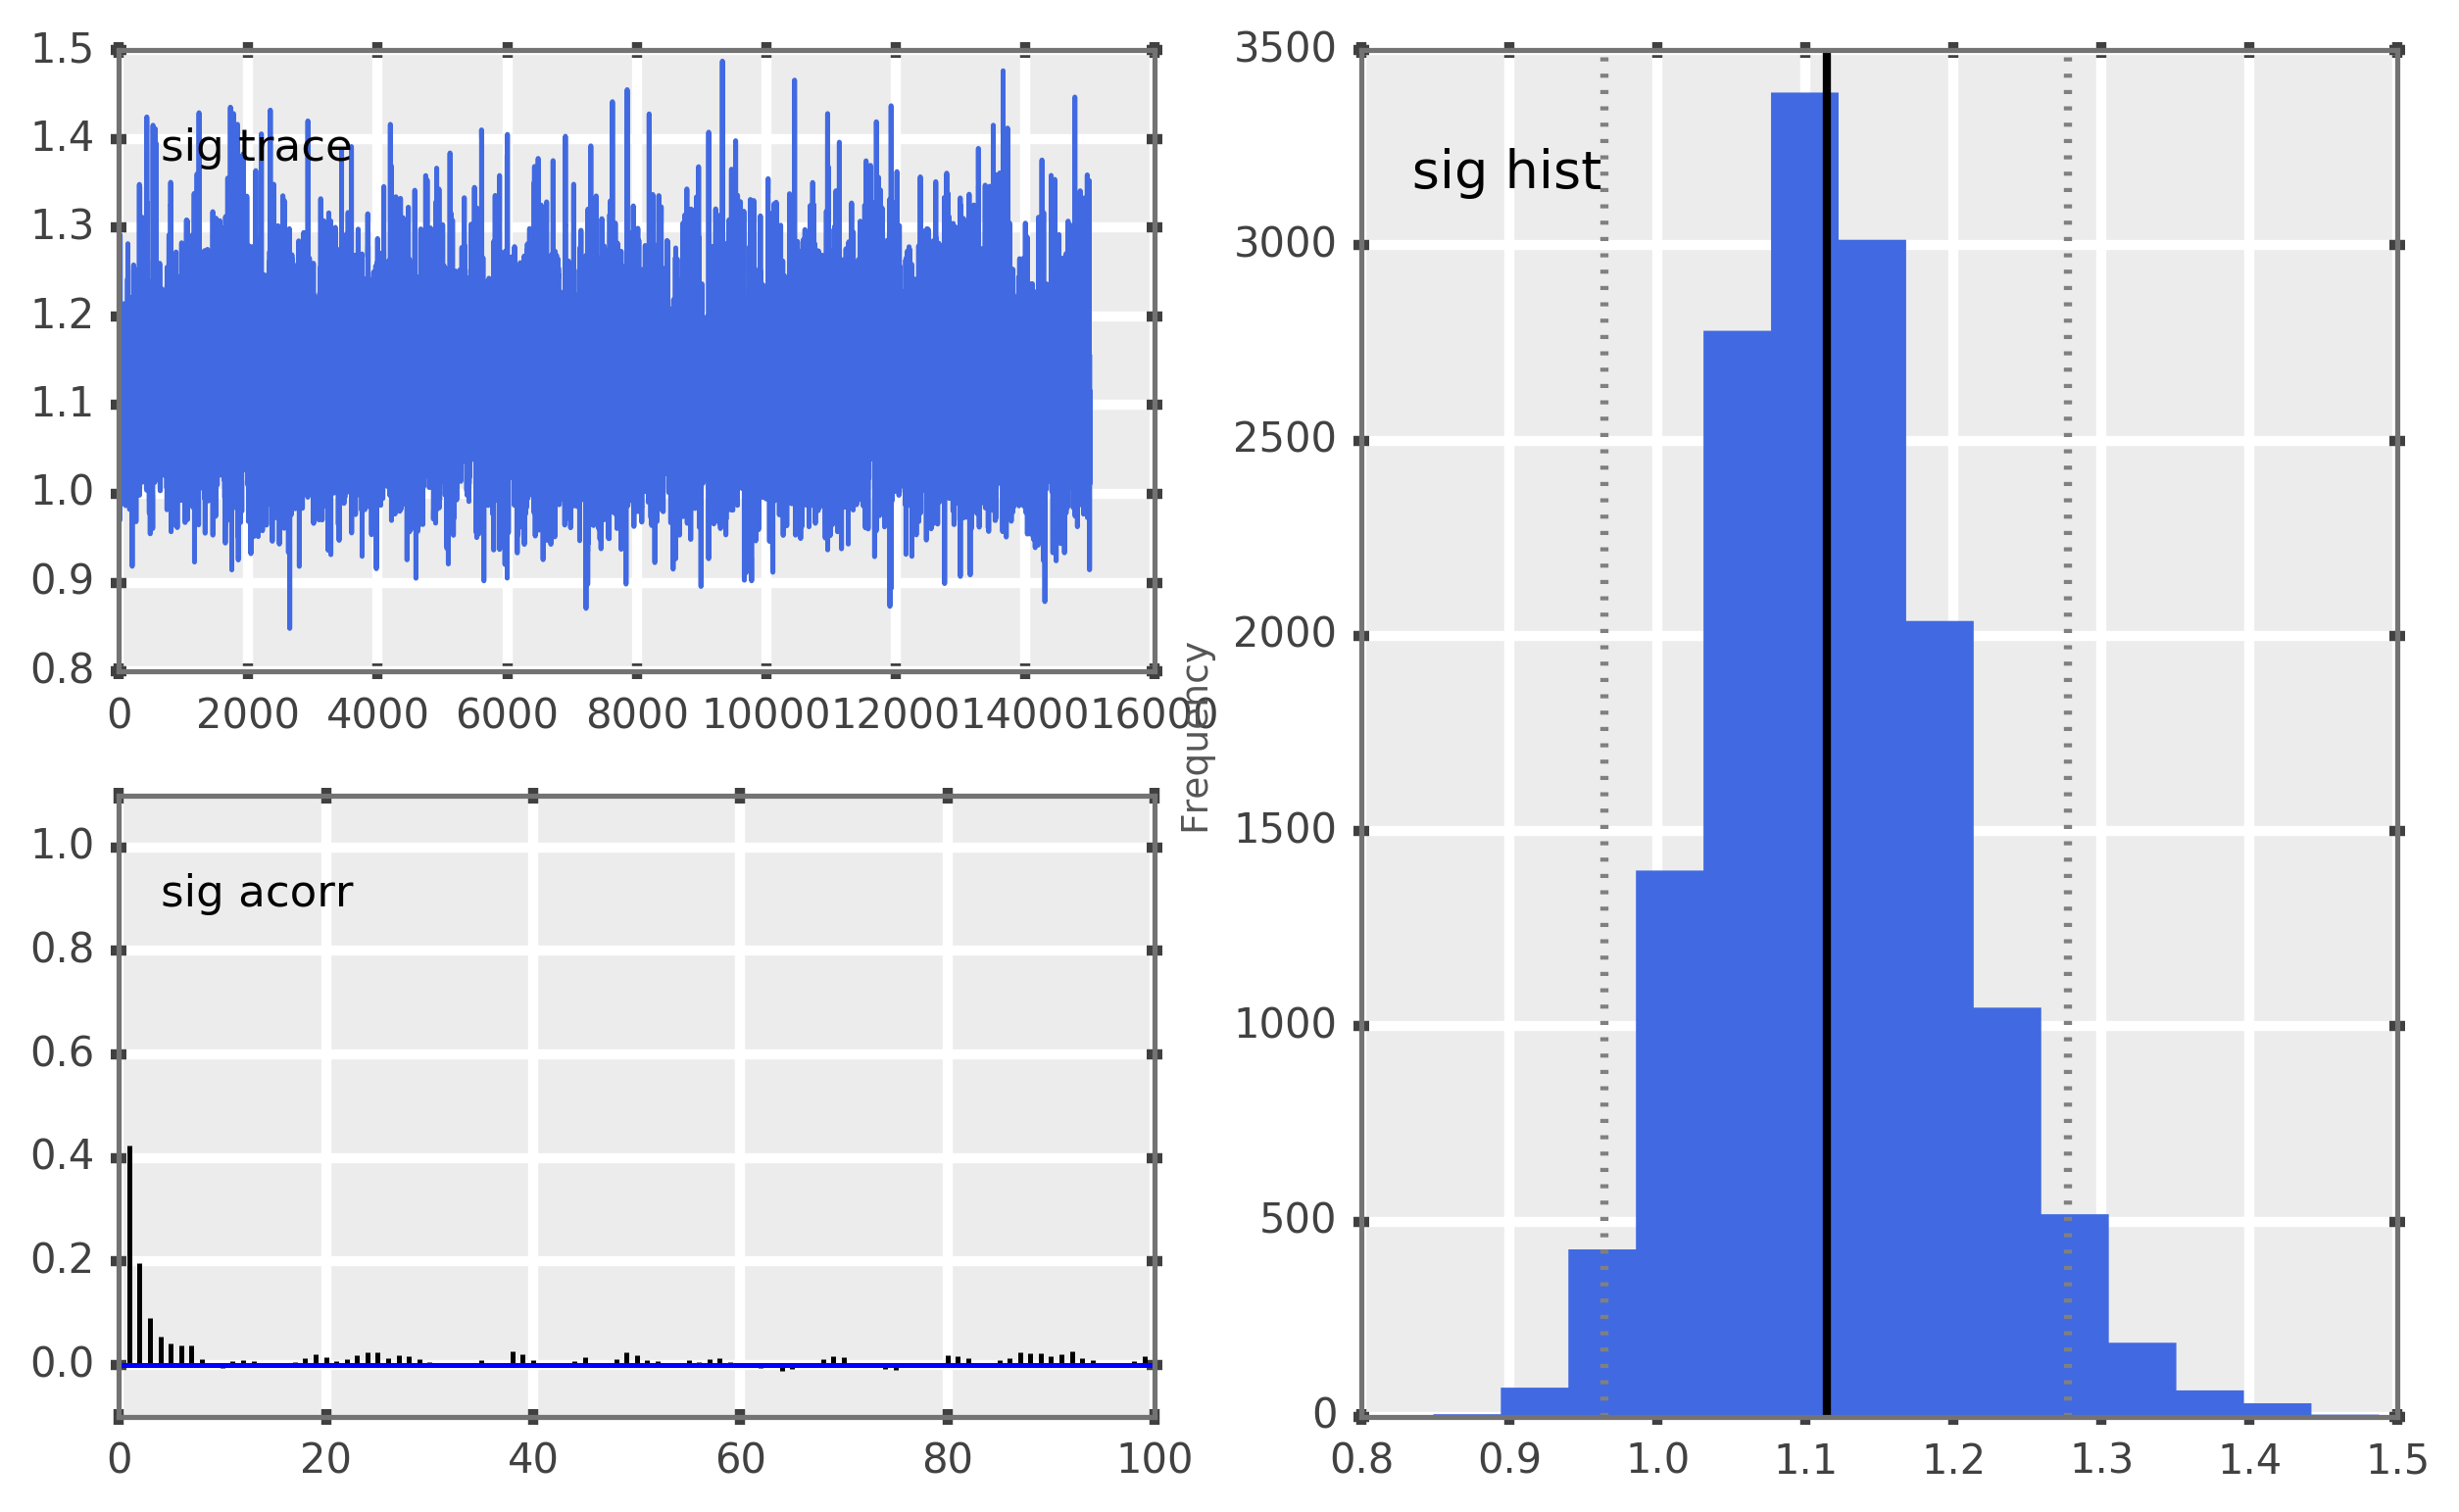

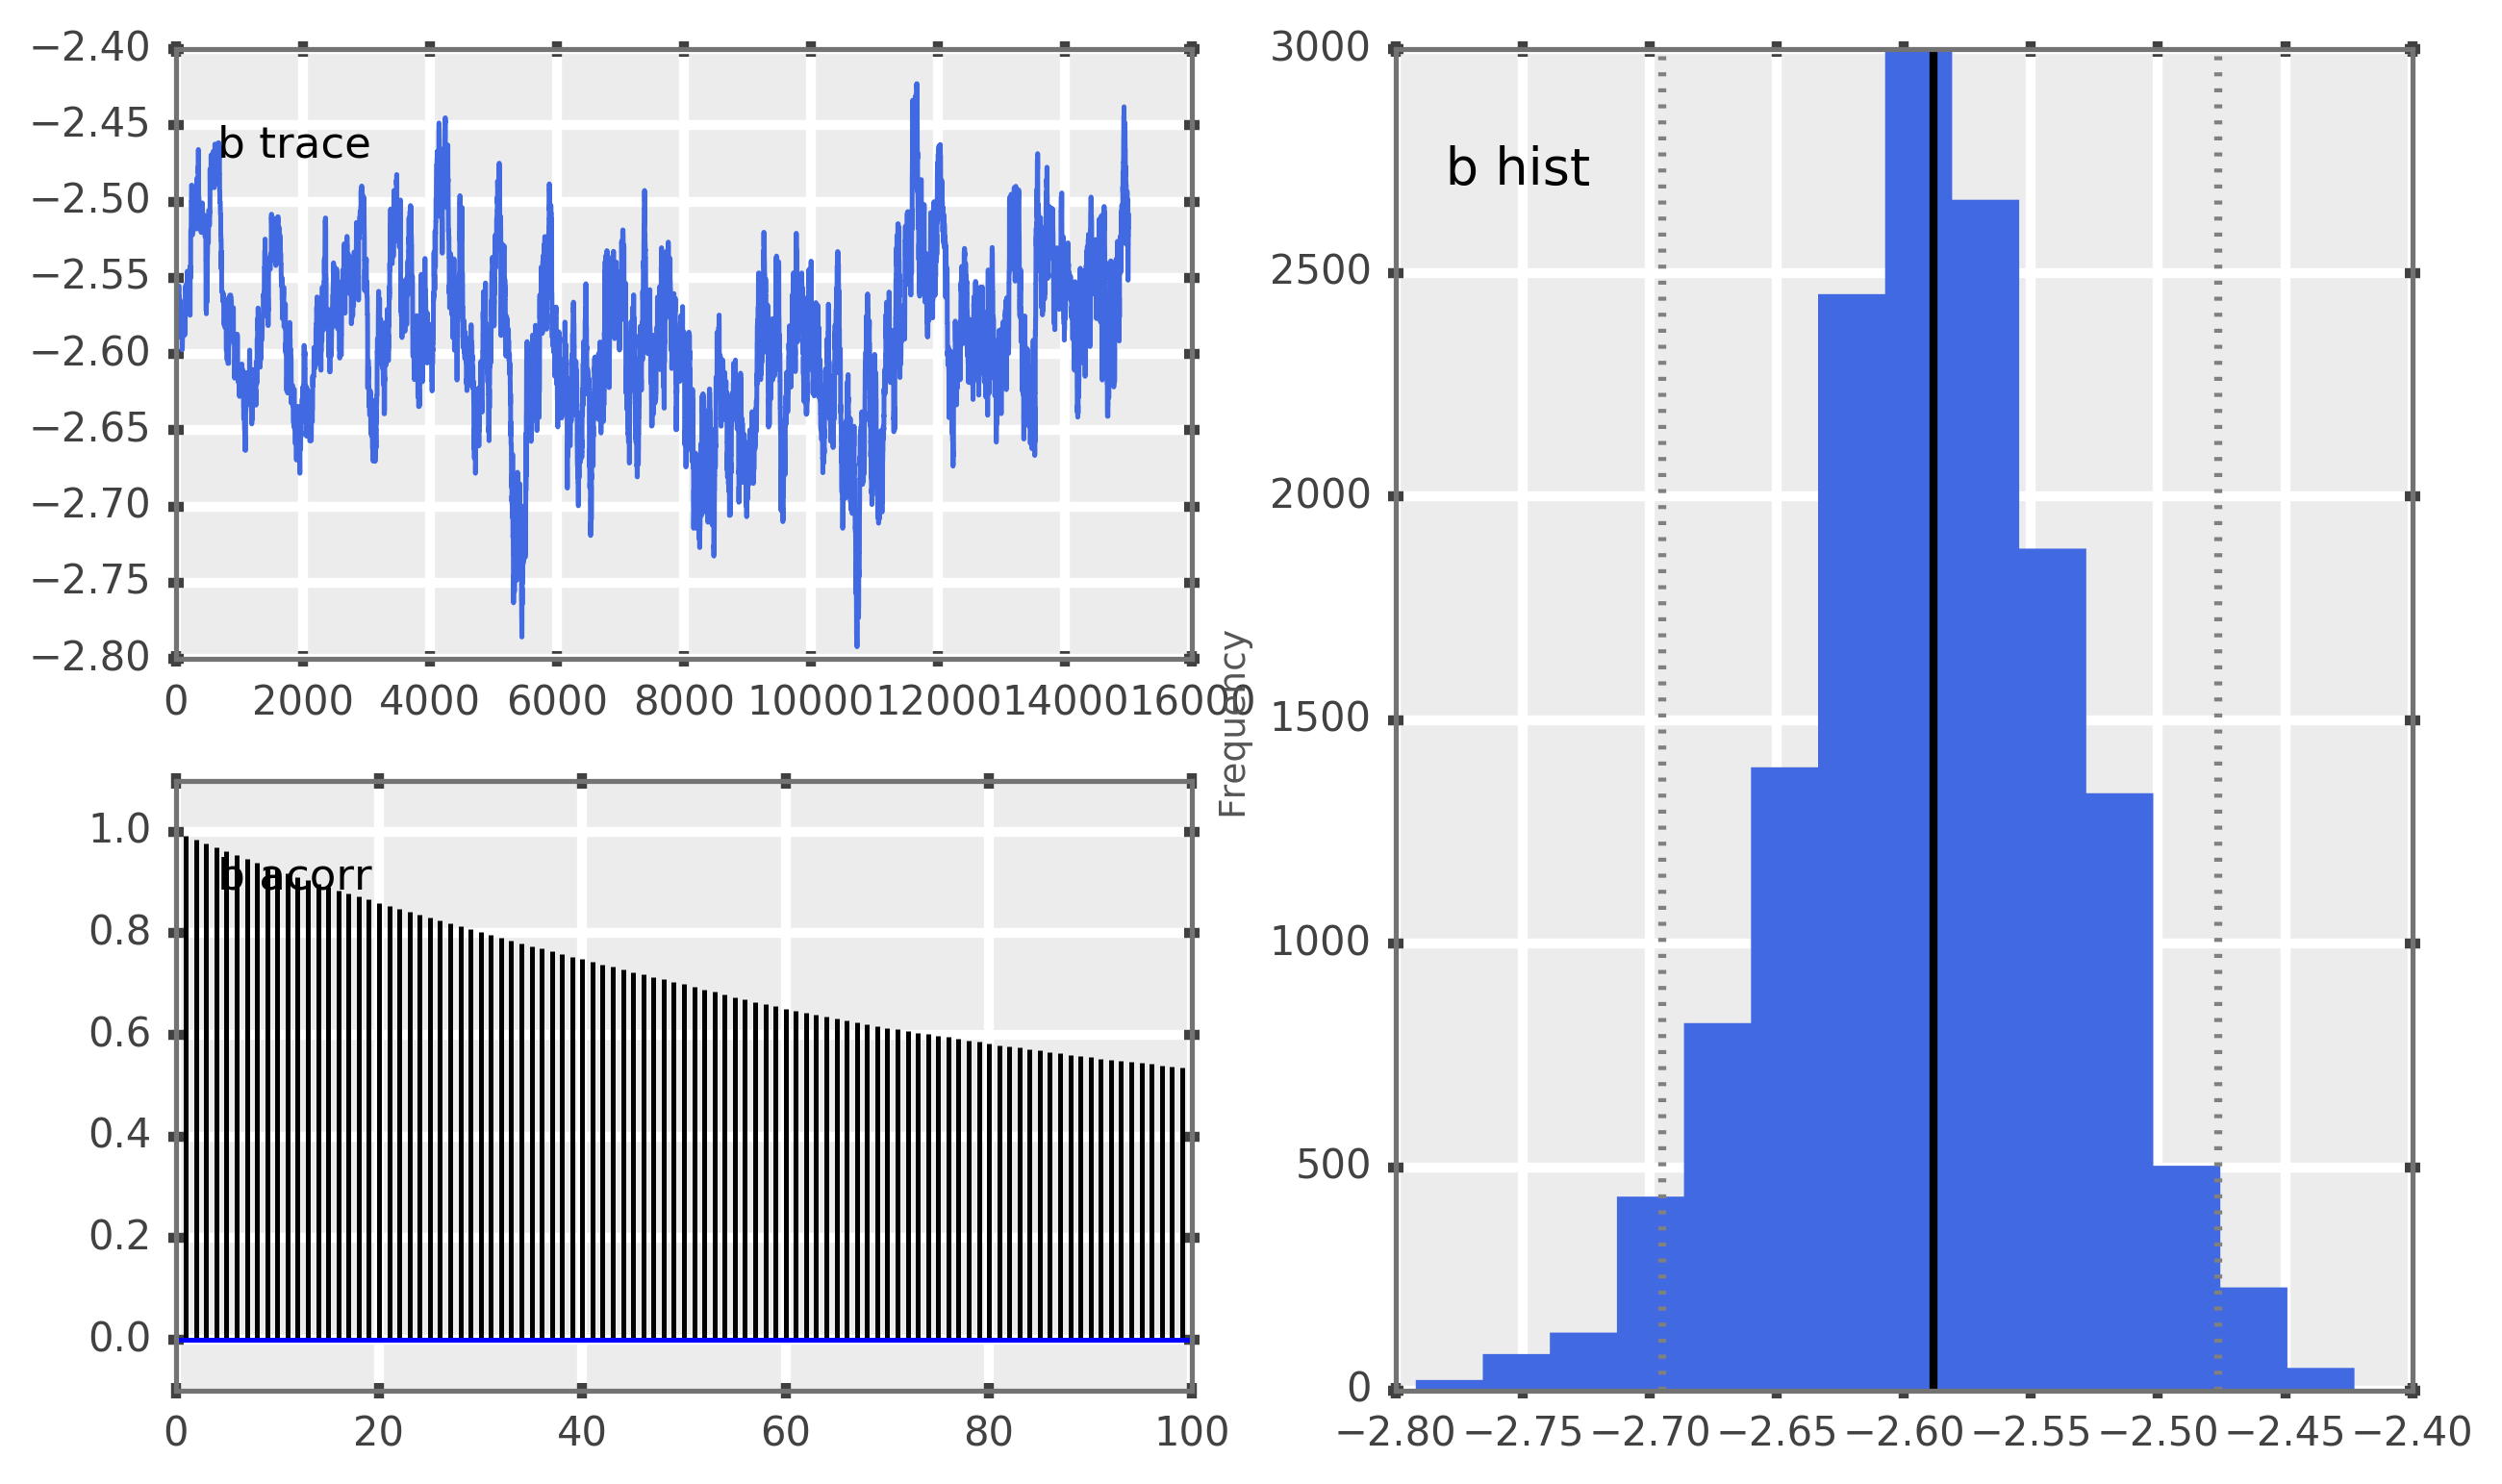

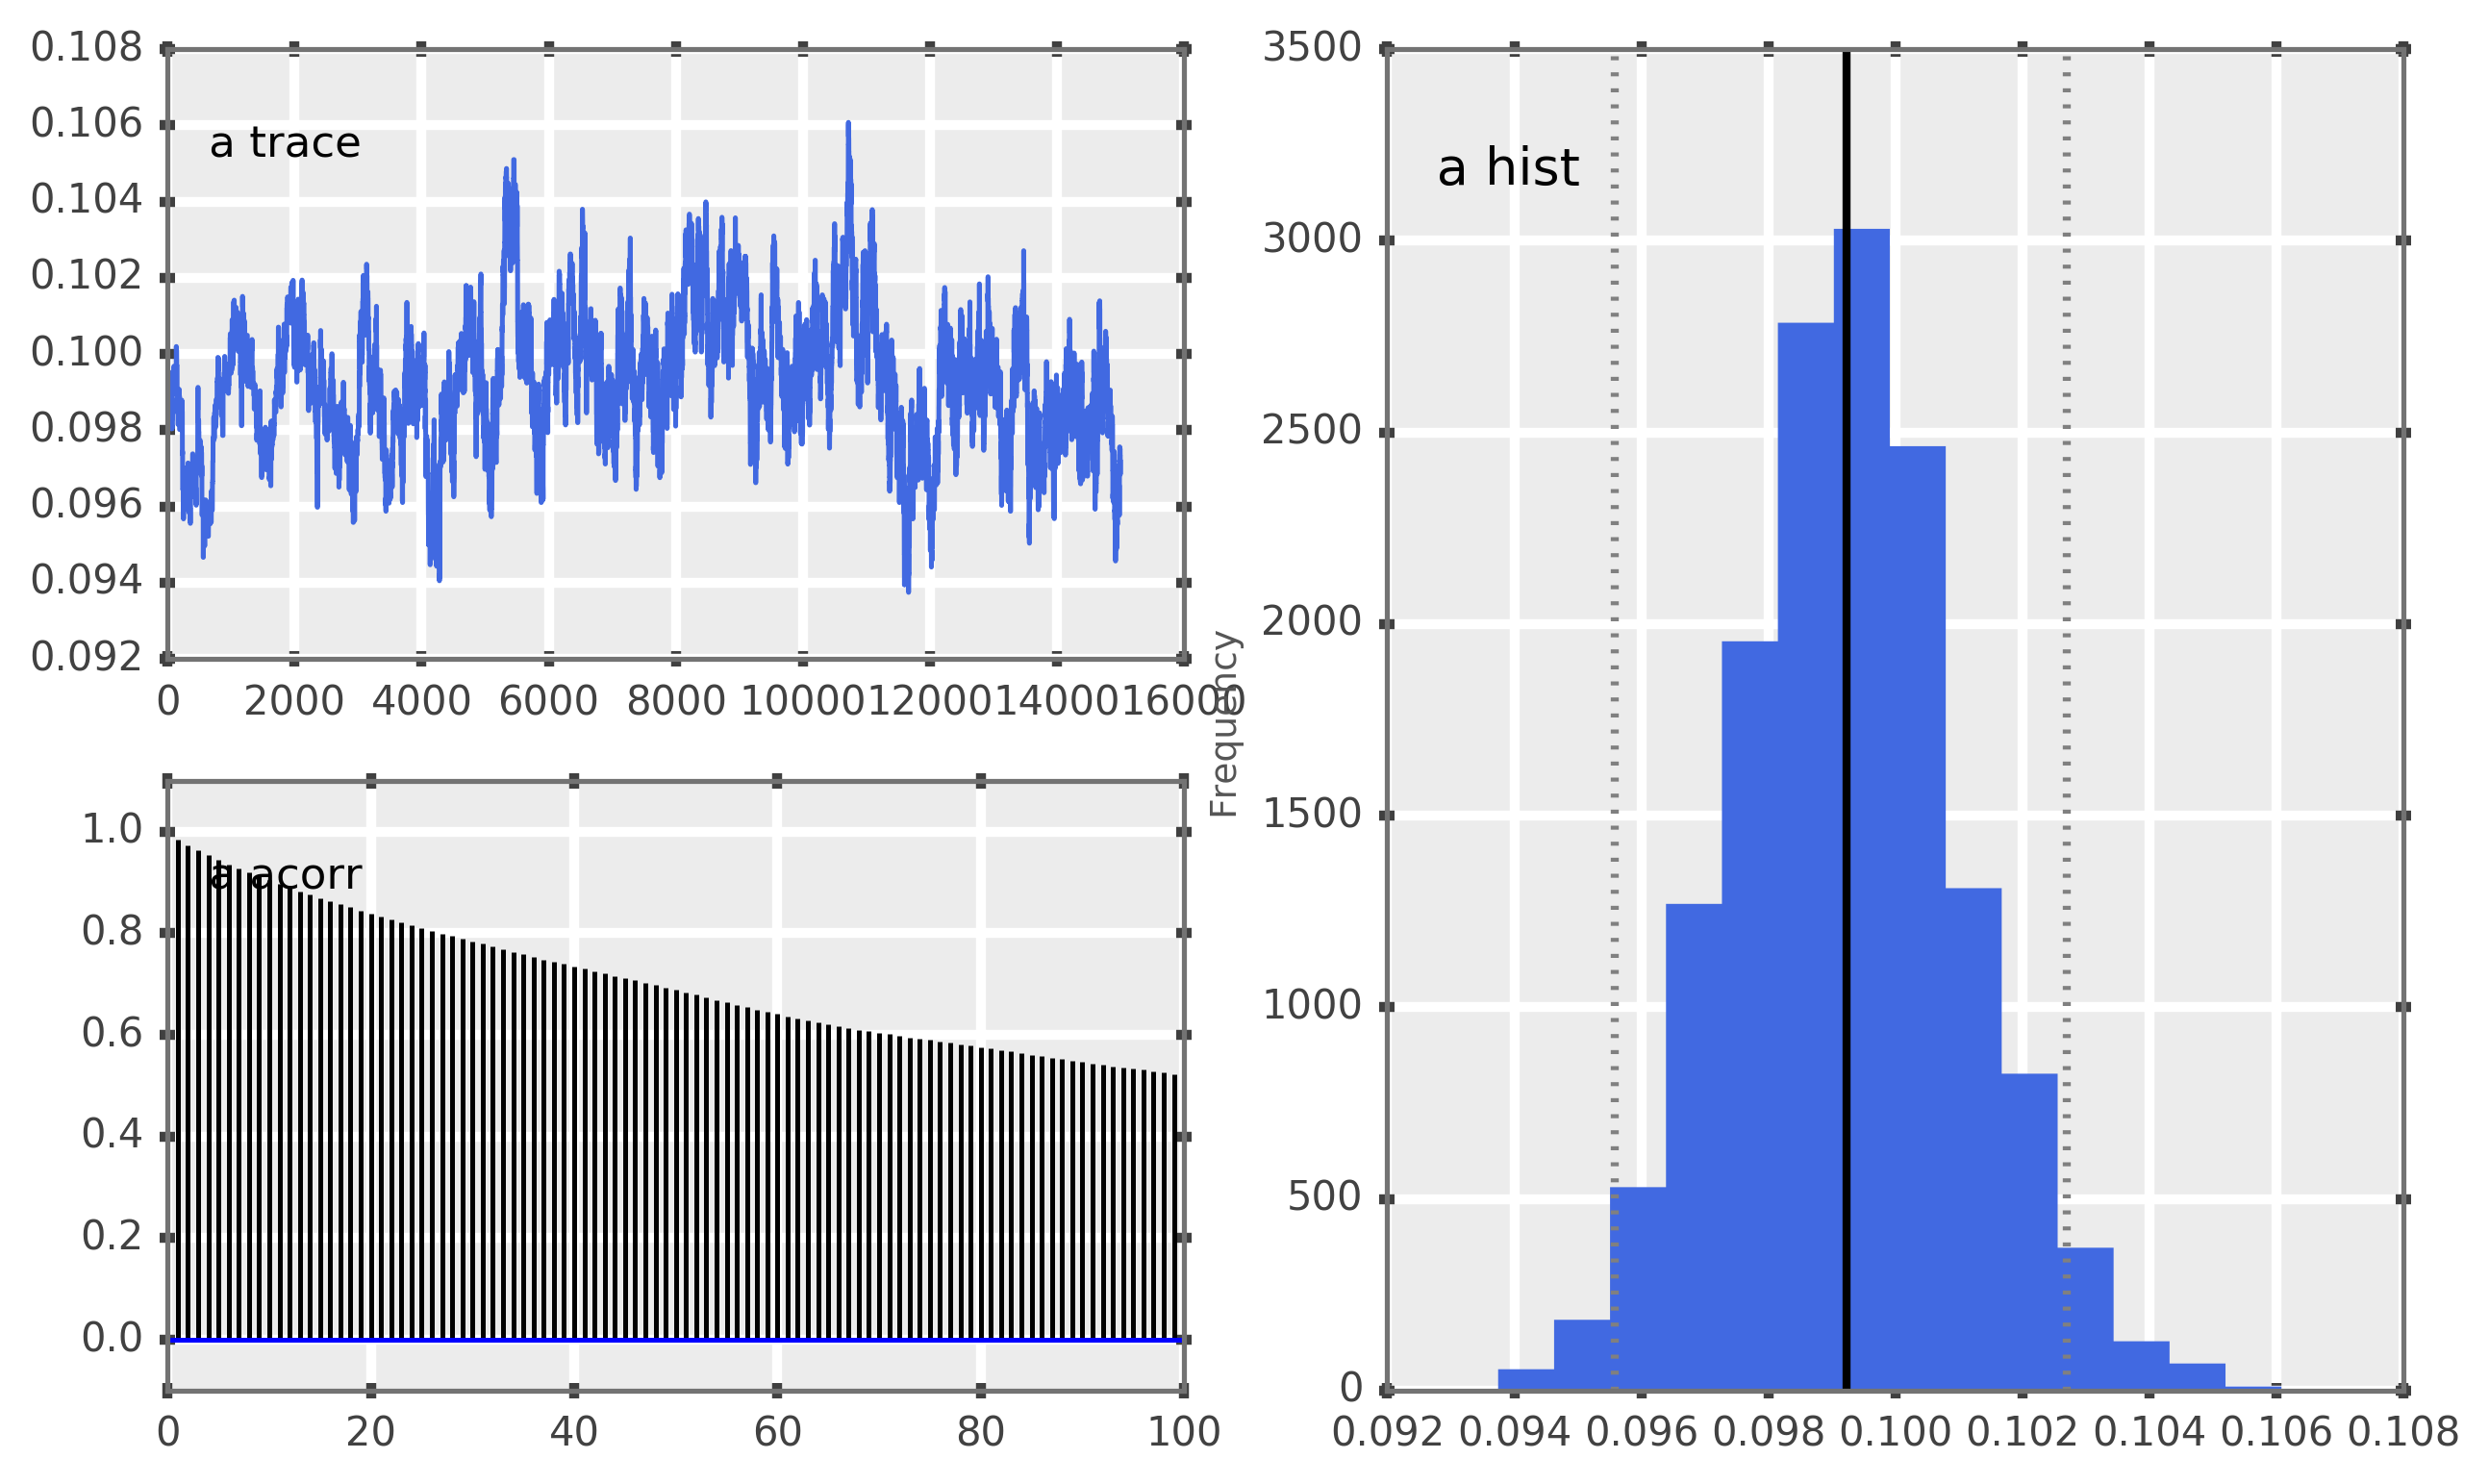

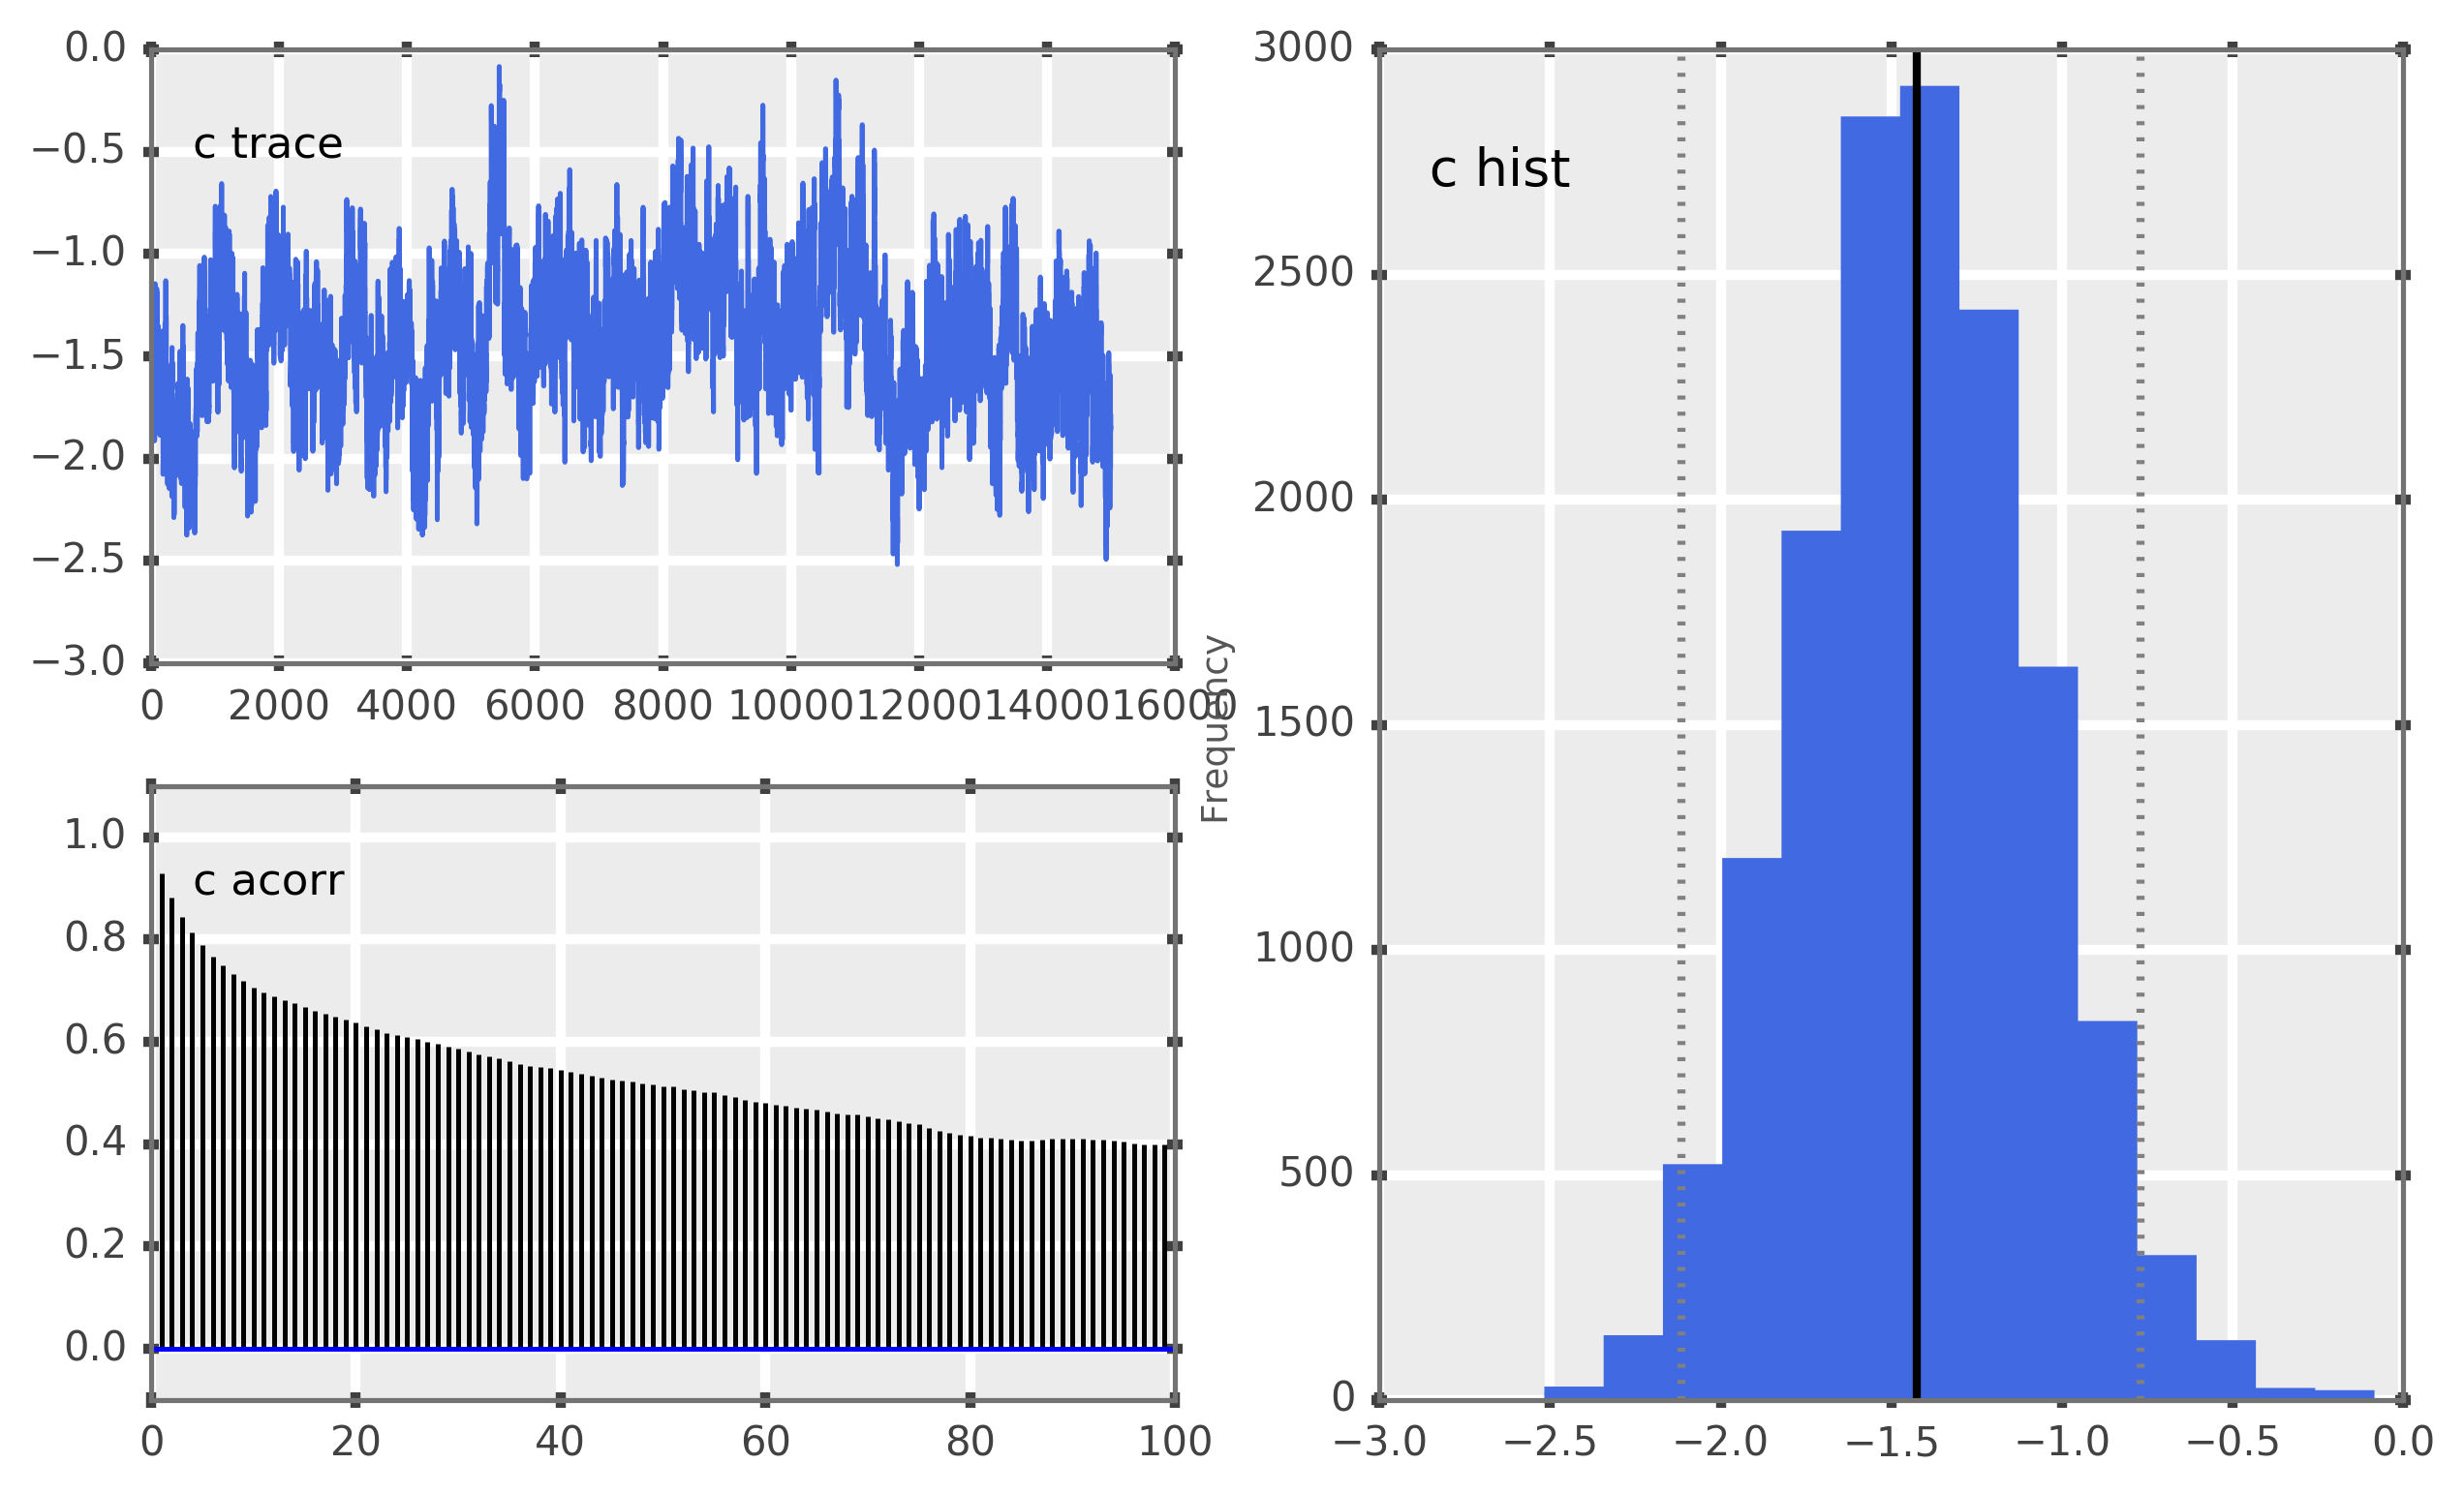

In [15]:

# Now, go to command line and run the following (or alternatively put them in a file):

R = pymc.MCMC({'sig':sig, 'a':a, 'b':b, 'c':c, 'y':y})    #  build the model
R.sample(50000, 5000, thin=3)              # populate and run it
R.stats()
pymc.Matplot.summary_plot(R)
pymc.Matplot.plot(R)
R.summary()


In [16]:
R.get_node('a').get_value()
np.mean(R.a.trace[...])
np.percentile(R.a.trace[...], [2.5, 50, 97.5])
R.a.value
R.y.value

array([ -0.82453927,  -4.3138014 ,  -2.77565275,  -2.28606476,
        -5.49230648,  -5.53964496,  -6.25850689,  -6.69156649,
        -6.63308185,  -8.43777563,  -8.17813962,  -9.24560217,
       -10.58319072, -11.26105994,  -9.86493137,  -9.83129889,
       -12.77401102, -11.97880673, -11.72609902, -12.98661521,
       -12.19015908, -13.30767622, -13.66015304, -15.22721976,
       -13.28636275, -14.71547751, -15.10094932, -14.55905401,
       -16.05175797, -14.88190441, -15.65021516, -17.034762  ,
       -17.97961542, -17.6873864 , -16.49436585, -17.86702968,
       -17.18345002, -18.91726137, -16.38552753, -19.30946933,
       -18.10229558, -18.58260189, -18.25281995, -19.9154886 ,
       -19.06170619, -18.17506685, -17.68343452, -18.80294741,
       -17.53320626, -20.05255593, -16.74856655, -16.41158917,
       -17.73547858, -20.08796085, -15.7868987 , -17.6745986 ,
       -16.82341822, -16.18378414, -16.76005757, -16.87520882,
       -15.50440619, -15.07907735, -16.75257762, -14.03

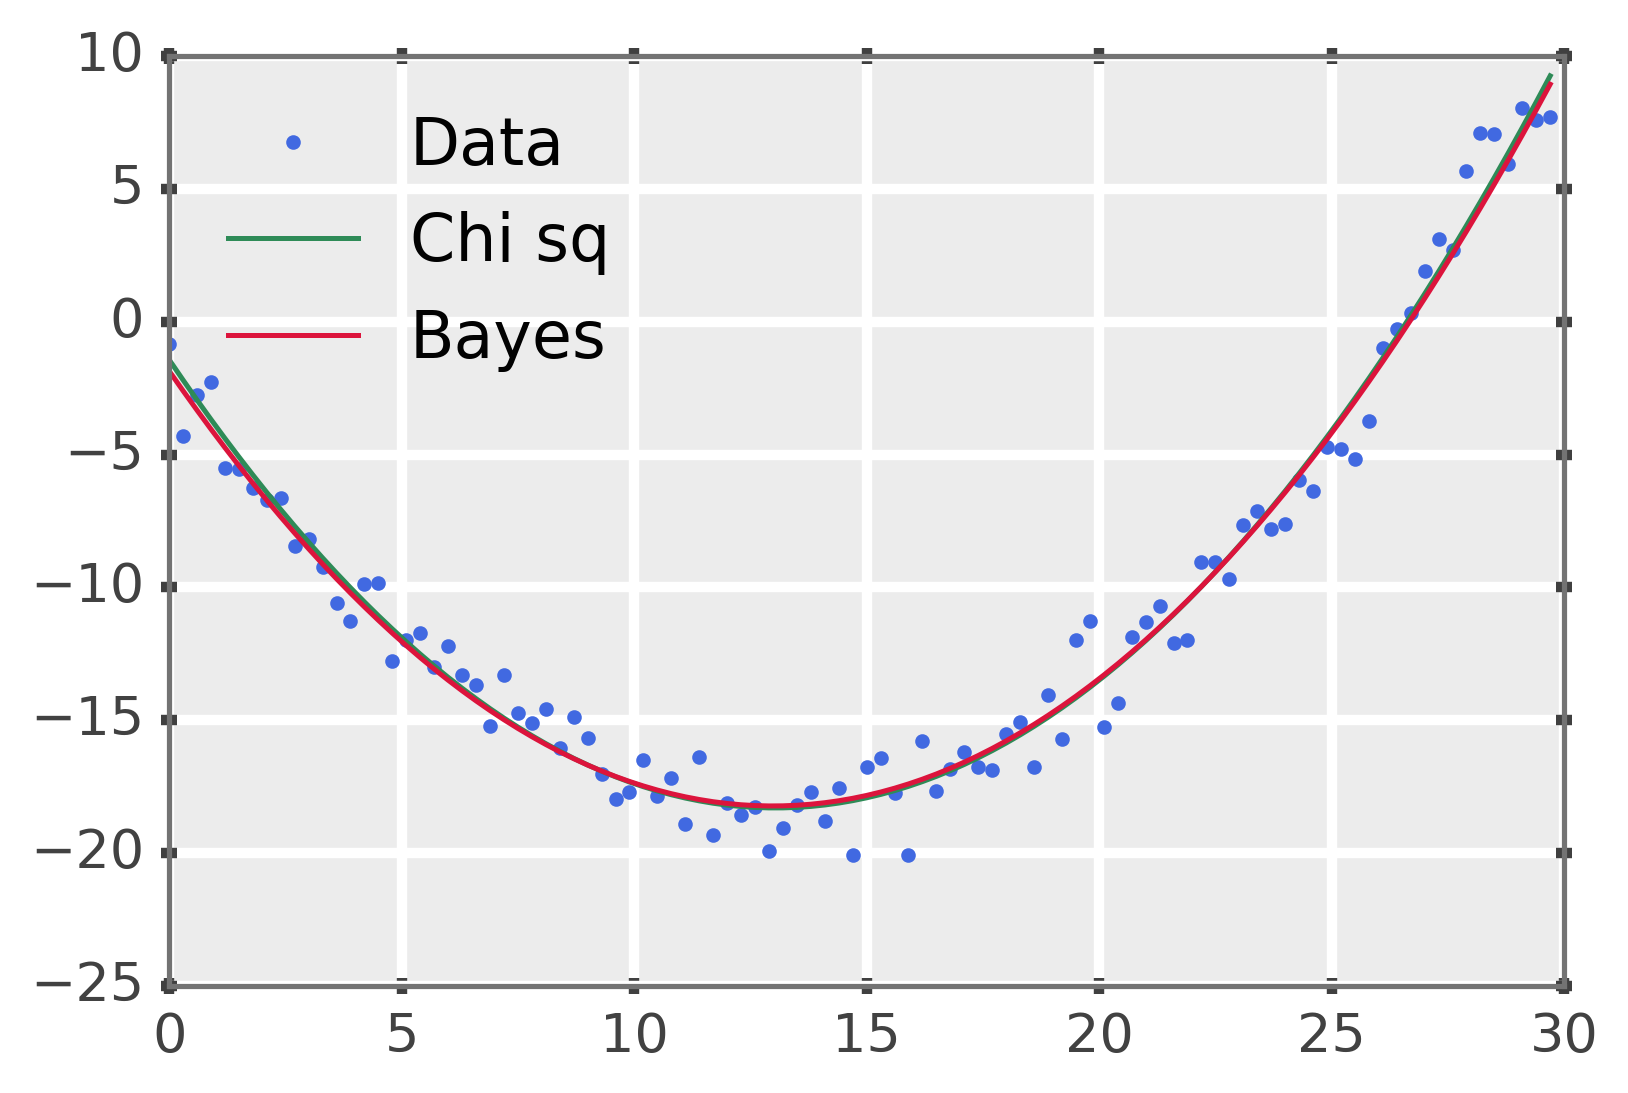

In [17]:
plt.plot(x, f, '.', label='Data')
plt.plot(x,z[0]*x**2 + z[1]*x + z[2], label='Chi sq')
plt.plot(x, R.a.value*x**2 + 
         R.b.value*x + 
         R.c.value, label='Bayes')
plt.legend(loc='upper left')

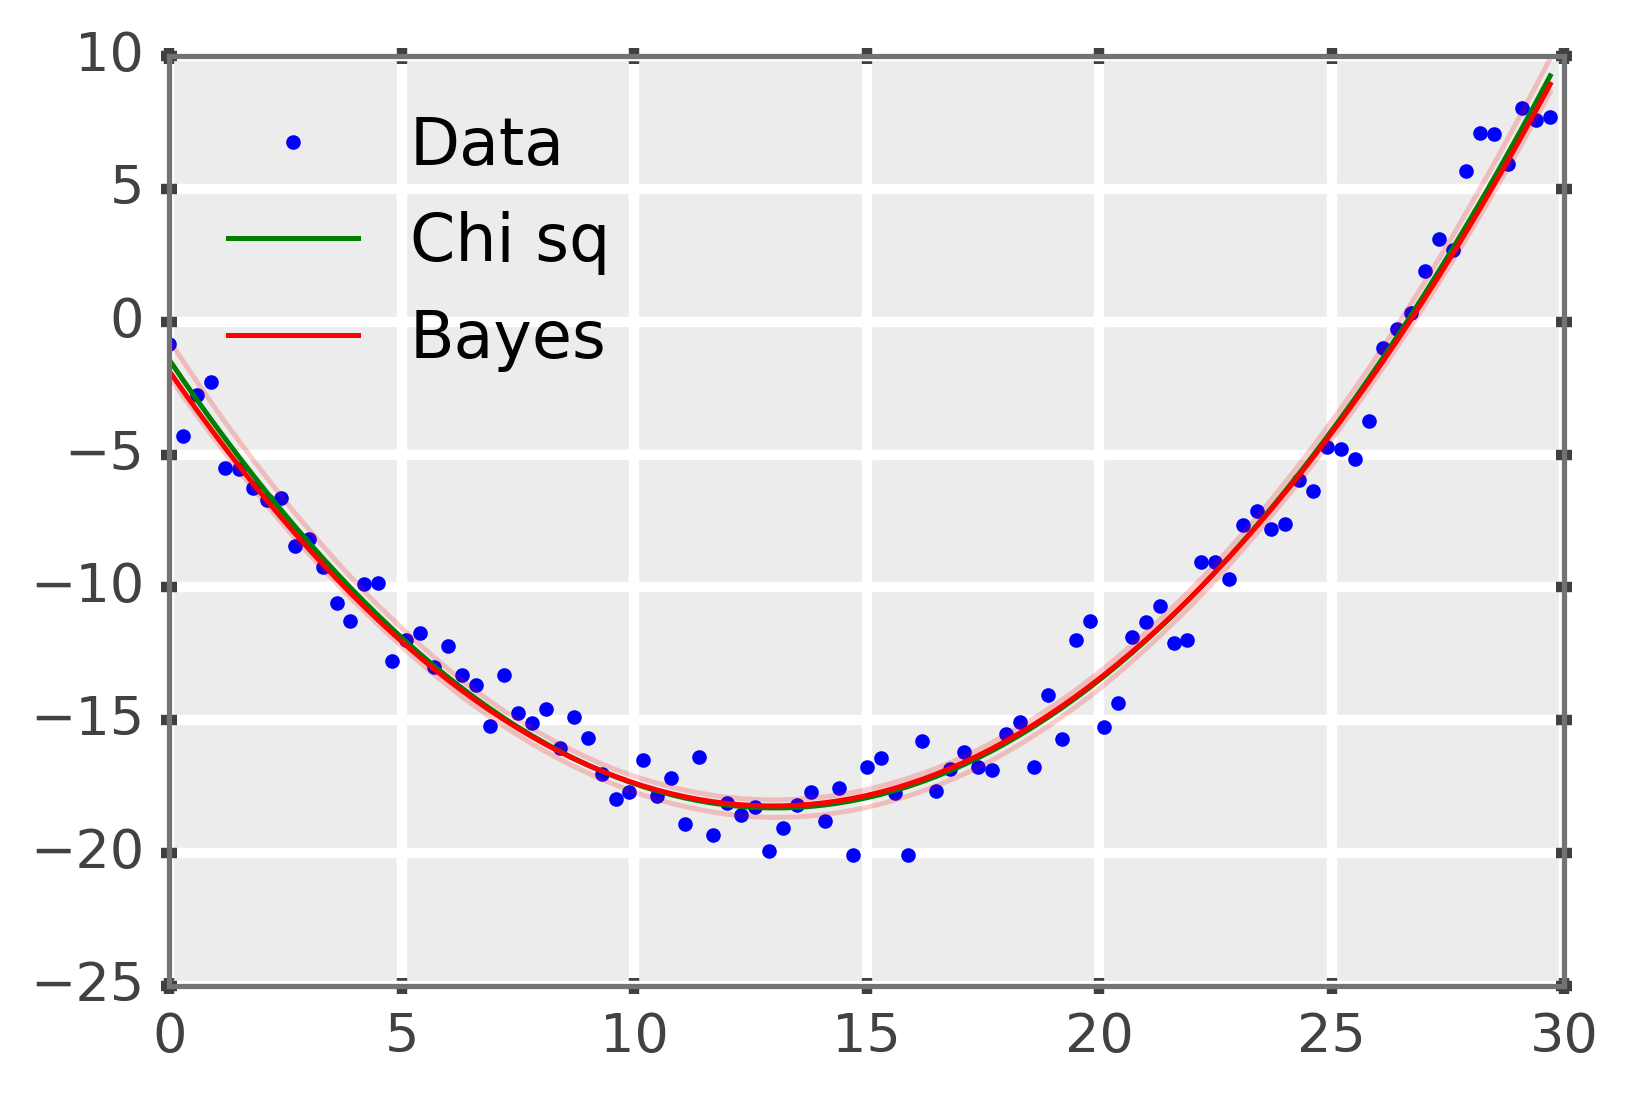

In [18]:
plt.plot(x, f, '.', label='Data', c='b')
plt.plot(x,z[0]*x**2 + z[1]*x + z[2], label='Chi sq', c='g')
plt.plot(x, R.a.value*x**2 + 
         R.b.value*x + 
         R.c.value, label='Bayes', c='r')
plt.legend(loc='upper left')

ind = np.random.random_integers(len(R.a.trace[...])-1, size=1000)
vals = np.zeros([len(x), len(ind)], dtype=float)
for ii, i in enumerate(ind):
    vals[:,ii] = R.a.trace[...][i]*x**2 + R.b.trace[...][i]*x + R.c.trace[...][i]
plt.plot(x, np.percentile(vals, 2.5, axis=1), c='r', alpha=0.2)
plt.plot(x, np.percentile(vals, 97.5, axis=1), c='r', alpha=0.2)

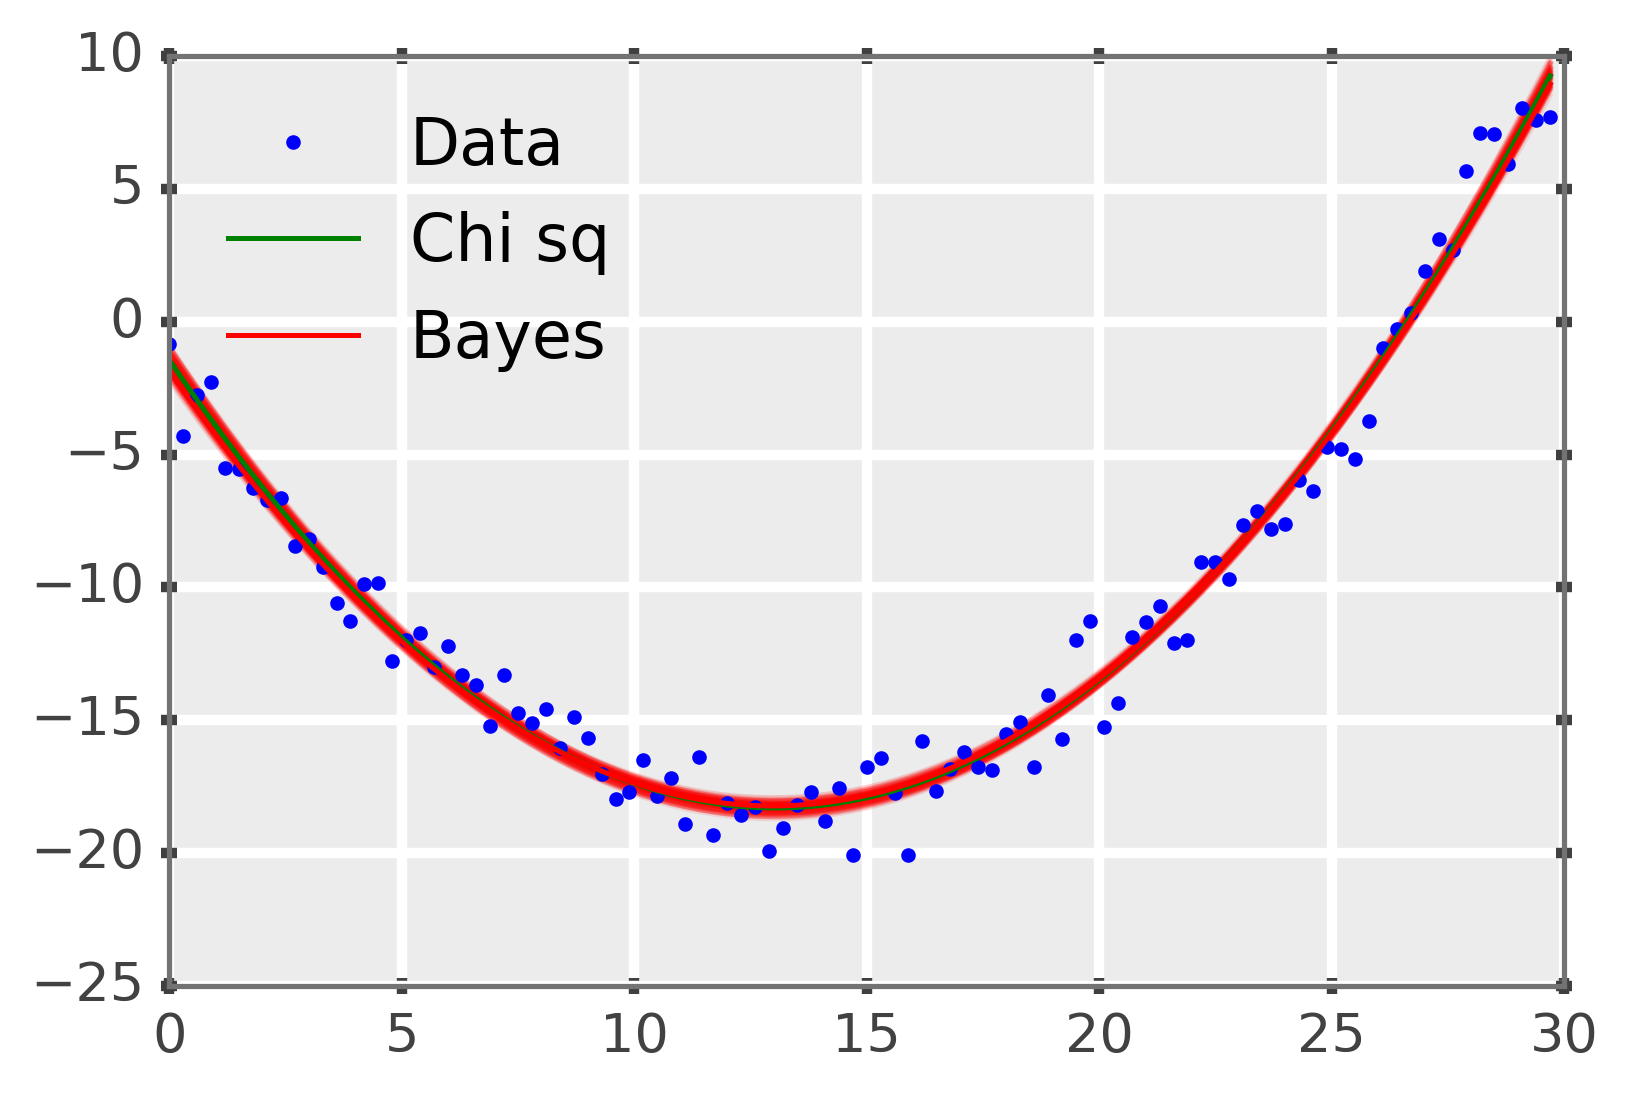

In [19]:



ind = np.random.random_integers(len(R.a.trace[...])-1, size=100)
vals = np.zeros([len(x), len(ind)], dtype=float)
for ii, trace in enumerate(ind):
    vals[:,ii] = R.a.trace[...][trace]*x**2 + R.b.trace[...][trace]*x + R.c.trace[...][trace]
    plt.plot(x, vals[:,ii], c='r', alpha=0.1)

plt.plot(x, f, '.', label='Data', c='b')
plt.plot(x,z[0]*x**2 + z[1]*x + z[2], label='Chi sq', c='g')
plt.plot(x, R.a.value*x**2 + 
         R.b.value*x + 
         R.c.value, label='Bayes', c='r')
plt.legend(loc='upper left')

In [20]:
# get the median absolute deviation of the residuals for each method
res1 = np.abs(f-z[0]*x**2 + z[1]*x + z[2])
mad1 = tb.medAbsDev(res1)
res2 = np.abs(f-R.a.value*x**2 + 
         R.b.value*x + 
         R.c.value)
mad2 = tb.medAbsDev(res2)
print('Chi sq MedAbsDev: {0}'.format(mad1))
print('Bayes MedAbsDev: {0}'.format(mad2))



Chi sq MedAbsDev: 38.909611414155286
Bayes MedAbsDev: 37.95097132291042


In [21]:
print(z, (R.a.value, R.b.value, R.c.value))

[ 0.09924399 -2.58796431 -1.42786014] (array(0.097165101715028), array(-2.5225124190217882), array(-1.8523371482228195))
